# Imports

In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   History, Model,
                   ModelResult, MedianEpsilon)
from pyabc.transition import MultivariateNormalTransition
from pyabc.visualization import plot_kde_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'
import os
import tempfile
import math
import pandas as pd
import scipy as sp
import numpy as np
import subprocess
from io import BytesIO

from pyabc_custom import MyokitSimulation
from prangle_distance import PrangleDistance,PranglePopulationSize,PrangleEpsilon

# Get experimental measurements

In [2]:
myokit_python = ('/tmp/chouston/miniconda3/envs' +
                 '/ion_channel_ABC/bin/python')
args = [myokit_python, 'get_measurements.py']
args.append('ik1')
re = subprocess.run(args, stdout=subprocess.PIPE)
measurements = pd.read_table(BytesIO(re.stdout),
                             delim_whitespace=True,
                             header=0, index_col=False)
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']

# Set limits and generate uniform initial priors

In [3]:
limits = dict(g_K1=(0, 1),
              k_1=(-1000, 1000),
              k_2=(0, 100),
              k_3=(0, 1),
              k_4=(0, 0.1))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Define ABC parameters and initialise database

In [4]:
myokit_model = MyokitSimulation('ik1')
#myokit_model.sample(prior.rvs())

In [15]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ik1.db"))

In [16]:
abc = ABCSMC(models=myokit_model,
             parameter_priors=prior,
             distance_function=PrangleDistance(
                 exp_map=exp,
                 alpha=0.5,
                 delta=0.5,
                 adapt=False),
             population_size=PranglePopulationSize(
                 500, alpha=0.5,
                 adapt=True,
                 mean_cv=0.5,
                 min_population_size=200,
                 max_population_size=5000),
             eps=PrangleEpsilon(100, alpha=0.5))

In [17]:
abc_id = abc.new(db_path, obs)

INFO:Epsilon:initial epsilon is 100
INFO:History:Start <ABCSMC(id=2, start_time=2018-06-28 15:50:23.248194, end_time=None)>


In [18]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=30)

INFO:ABC:t:0 M eps:[100]
INFO:ABC:t:0 N eps:57.86886741763661
INFO:ABC:N population size: 500
INFO:ABC:t:1 M eps:[100.          57.86886742]
INFO:Adaptation:Change nr particles 500 -> 200
INFO:ABC:t:1 N eps:41.348493401775855
INFO:ABC:N population size: 200
INFO:ABC:t:2 M eps:[100.          57.86886742  41.3484934 ]
INFO:Adaptation:Change nr particles 200 -> 200
INFO:ABC:t:2 N eps:30.733993903758662
INFO:ABC:N population size: 200
INFO:ABC:t:3 M eps:[100.          57.86886742  41.3484934   30.7339939 ]
INFO:Adaptation:Change nr particles 200 -> 200
INFO:ABC:t:3 N eps:21.543735526236343
INFO:ABC:N population size: 200
INFO:ABC:t:4 M eps:[100.          57.86886742  41.3484934   30.7339939   21.54373553]
INFO:Adaptation:Change nr particles 200 -> 200
INFO:ABC:t:4 N eps:15.865360997930717
INFO:ABC:N population size: 200
INFO:ABC:t:5 M eps:[100.          57.86886742  41.3484934   30.7339939   21.54373553
  15.865361  ]
INFO:Adaptation:Change nr particles 200 -> 200
INFO:ABC:t:5 N eps:11.454

INFO:Adaptation:Change nr particles 200 -> 200
INFO:ABC:t:26 N eps:2.2014963596918897
INFO:ABC:N population size: 200
INFO:ABC:t:27 M eps:[100.          57.86886742  41.3484934   30.7339939   21.54373553
  15.865361    11.45489551   8.36202753   6.64030937   5.45648274
   4.65000051   3.94152195   3.42485646   3.03967999   2.76550215
   2.55722978   2.44604943   2.36804741   2.30701872   2.27303712
   2.24594833   2.23204068   2.22020214   2.21242773   2.20762383
   2.20466492   2.20272988   2.20149636]
INFO:Adaptation:Change nr particles 200 -> 200
INFO:ABC:t:27 N eps:2.200684630004059
INFO:ABC:N population size: 200
INFO:ABC:t:28 M eps:[100.          57.86886742  41.3484934   30.7339939   21.54373553
  15.865361    11.45489551   8.36202753   6.64030937   5.45648274
   4.65000051   3.94152195   3.42485646   3.03967999   2.76550215
   2.55722978   2.44604943   2.36804741   2.30701872   2.27303712
   2.24594833   2.23204068   2.22020214   2.21242773   2.20762383
   2.20466492   2.202729

In [5]:
db_path = 'sqlite:///pyabc-runs/hl-1_ik1.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-06-28 12:01:58.509302, end_time=2018-06-28 13:51:51.949479)>,
 <ABCSMC(id=2, start_time=2018-06-28 15:50:23.248194, end_time=2018-06-28 17:00:40.715836)>]

In [6]:
history.id = 2

/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


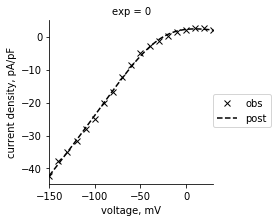

In [7]:
from visualization_custom import plot_sim_results
g = plot_sim_results(history, 'ik1', n_samples=10, obs=measurements, original=False)
xlabels = ["voltage, mV"]
ylabels = ["current density, pA/pF"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
plt.savefig('ik1_results.pdf', format='pdf', dpi=1000)

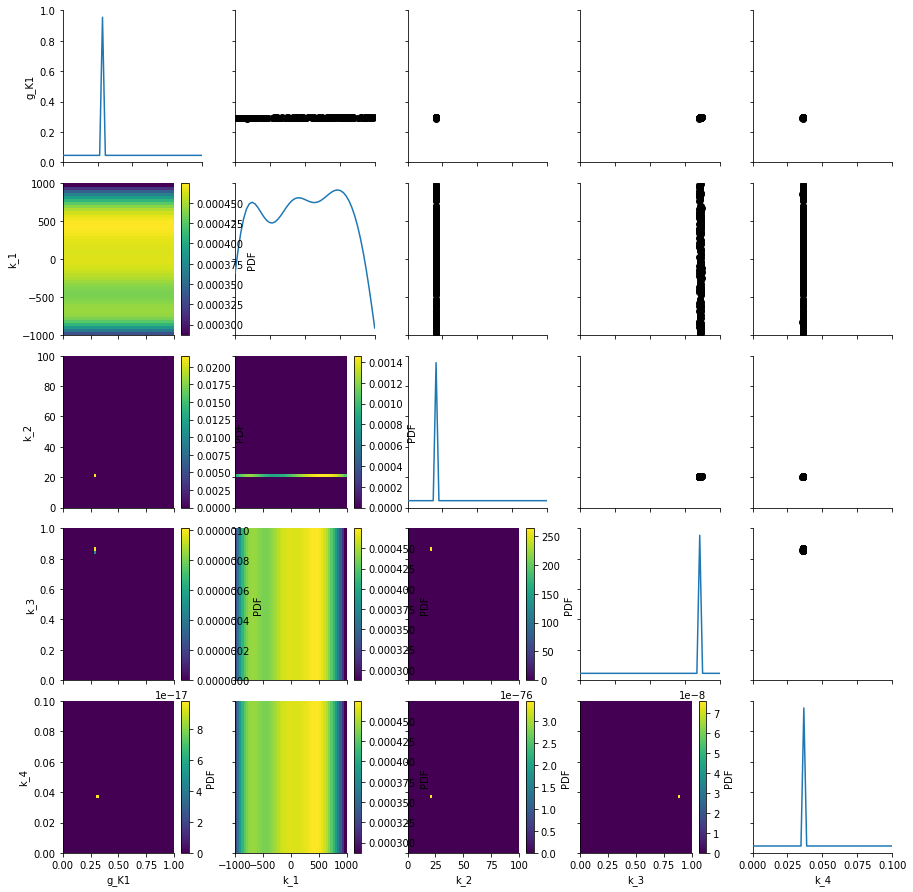

In [20]:
df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)

In [ ]:
db_path = 'sqlite:///pyabc-runs/hl-1_iha.db'
history = History(db_path)
history.all_runs()

In [20]:
df, w = history.get_distribution(m=0)
df['wt'] = w
print("Mean")
for key in limits.keys():
    print(key, ":", sum(df[key] * df.wt))
print("Min")
for key in limits.keys():
    print(key, ":", min(df[key]))
print("Max")
for key in limits.keys():
    print(key, ":", max(df[key]))

Mean
g_ha : 0.0909545290112378
k_yss1 : 60.673485181620215
k_yss2 : 4.973963743690542
k_ytau1 : 6.388599333218339
k_ytau2 : 0.2682961466391644
k_ytau3 : 26.874532037143872
k_ytau4 : 30.739228218502273
k_ytau5 : 0.5616847005125513
k_ytau6 : 50.9967573954618
k_ytau7 : 16.754660871957018
k_i_haNa : 0.17896991496636958
Min
g_ha : 0.08518742054378937
k_yss1 : 0.0785671050909329
k_yss2 : 0.005195917176980369
k_ytau1 : 0.45551704369577584
k_ytau2 : 5.020649955791989e-06
k_ytau3 : 0.006130500033115993
k_ytau4 : 0.2347219611373852
k_ytau5 : 0.03144217050833935
k_ytau6 : 9.28845711771259
k_ytau7 : 15.033165684005471
k_i_haNa : 0.1628378100820481
Max
g_ha : 0.09991955215255488
k_yss1 : 99.99986277988837
k_yss2 : 9.98918710210725
k_ytau1 : 9.99774507962944
k_ytau2 : 0.9979365943204859
k_ytau3 : 98.87417426649652
k_ytau4 : 99.97183153931509
k_ytau5 : 0.9993087488619901
k_ytau6 : 89.65894229560229
k_ytau7 : 19.390881127410935
k_i_haNa : 0.19436511380204616


run
0     AxesSubplot(0.125,0.125;0.775x0.755)
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
13    AxesSubplot(0.125,0.125;0.775x0.755)
14    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

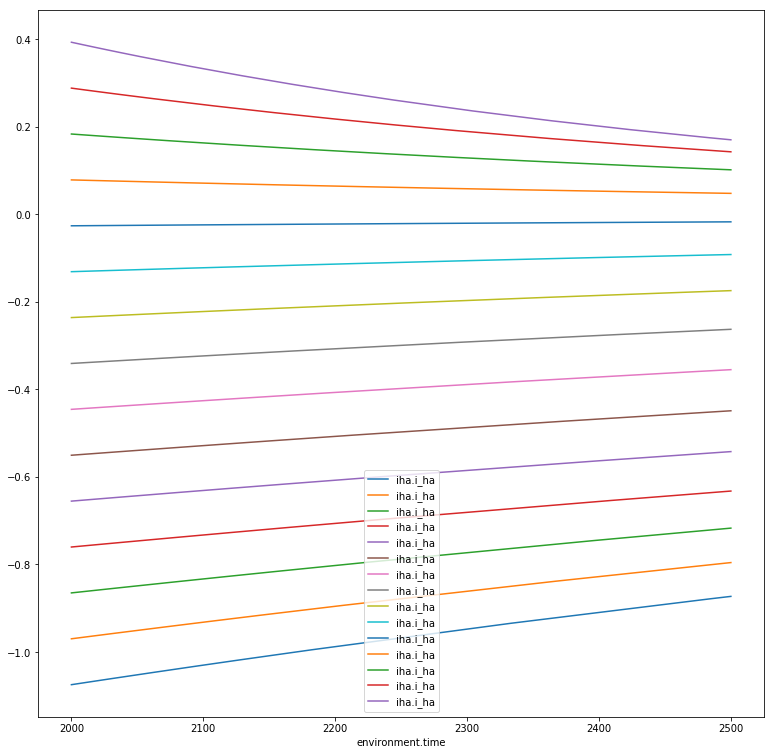

In [21]:
from pyabc_custom import simulate
out = simulate('iha', experiment=0, logvars=['environment.time', 'iha.i_ha'])
fig,ax = plt.subplots(figsize=(13,13))
out.groupby("run").plot(x="environment.time", y="iha.i_ha",ax=ax)